In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import gc
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
pd.set_option('max_colwidth', 200)

warnings.filterwarnings('ignore')
tqdm.pandas()

%matplotlib inline

In [2]:
# 节省内存读文件
def reduce_mem_usage(df):
    """
    iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    @param df:
    @return:
    """
    start_mem = df.memory_usage().sum()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('str')

    end_mem = df.memory_usage().sum()
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

### 用户表

In [3]:
train_user = reduce_mem_usage(pd.read_csv('../input/train/train_user.csv'))
test_user = reduce_mem_usage(pd.read_csv('../input/test/test_user.csv'))

Memory usage of dataframe is 635104.00 MB
Memory usage after optimization is: 256532.00 MB
Decreased by 59.6%
Memory usage of dataframe is 81880.00 MB
Memory usage after optimization is: 55295.00 MB
Decreased by 32.5%


In [4]:
train_user.head()

,phone_no_m,city_name,county_name,idcard_cnt,arpu_201908,arpu_201909,arpu_201910,arpu_201911,arpu_201912,arpu_202001,arpu_202002,arpu_202003,label
0,672ddbf02a5544d32e4ecc9433b1981bffe23bf912273a3a835f6cccb78b8ed7554e9ab0fbcd33d19eb6063ce00542dd223cc5cc83c68f07bcf933547b6776b1,绵阳,江油分公司,1,46.062500,45.000000,45.000,45.00000,45.00000,45.00000,45.00000,45.000000,0
1,5e1272273e041e82cb275ae877710be98cdaf5b0a8f34de8d361f71d5268fa0851edffd3950e170df1e3846fcf90cc7cc8299be9139a2ac4b5c5e5121d832674,德阳,旌阳分公司,1,79.000000,79.187500,79.125,79.31250,41.40625,34.09375,59.40625,60.000000,0
2,eaab3472ec87b076e69e6e8bb62b14341638fc63661a6c682d6add360a4332a8ad294d8470d64a73c6e53e8413f0ad93b9ea65afab717e58d312554f33553ee7,成都,金堂分公司,2,18.843750,24.453125,22.000,21.40625,22.15625,21.09375,61.31250,63.000000,0
3,0ce1bb415704178bf44e9c9b431a39b083a132c8e6d99f3627cd4520064b93ec66a72d085a67f0f40eebb9f901072965073e398f04c4ae500a1db4dfb13a972c,成都,高新分公司,2,19.203125,29.656250,130.375,173.12500,19.00000,19.00000,19.00000,23.203125,0
4,28b87f35f63f65096a53e3a4c97eaffd4a6c43ffa7e92d7706b20520aa11fff0f4ce06203f66758ec0f0e70780e4e258aae6aa1f23439e115528e08eda71ed20,德阳,旌阳分公司,1,50.000000,50.000000,50.000,50.00000,50.00000,50.00000,50.00000,50.000000,0


In [5]:
test_user.head()

,phone_no_m,city_name,county_name,idcard_cnt,arpu_202004
0,22d522340df77e2252c1a4d92b4bcb00d515e36f3ec6bf94e017b4ffd67e26520af18637ad91bde69abd831cc36cdc0c5af5e57bc280f95f79efef7bfa9c6926,成都,金牛分公司,1,9.00
1,5220d4b8429bdba3971a7b46a088c6b8fa6710f40607598ac1219daab6071510b3f66f78637420574dbb2d5488d44de9d4360a644bbe4ec45aaa4b7513bdc886,天府新区,天府直属部门,1,NaN
2,7d19dd2b50ced56f03d23bf928cf34dc570a48525571a868ffdcdc53a865b7a41c386a6f1d6567dd4a710530b933308c77d1ef89f77b580d1983dadd3de162ea,成都,锦江分公司,1,9.00
3,134a4a591185c9d3788021896dcfc235e9e0a6a1e3f8a4fd3a9f9d9bf4a033e791b7199db980b0678020bdf689d719306a5c694ffa47b4ba2bec43ceda68dfc1,绵阳,江油分公司,1,138.75
4,2356dcd6759d50455ddaeed03c838843558e9182d5962f8a4c81a9a178063c49ab988750f795bb6c5462aee5dace2ad9fd18dbb1a6619dbb1e771e9b0f192da9,成都,青羊分公司,2,39.00


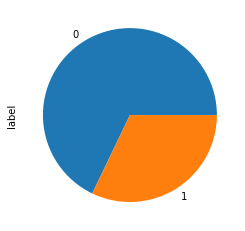

In [6]:
train_user.label.value_counts().plot.pie()

In [7]:
train_user['label'].mean()

0.321323288568621

In [8]:
train_user.shape, test_user.shape

((6106, 13), (2045, 5))

In [9]:
# 训练集只取最后一个月的数据
train_user['arpu_202004'] = train_user['arpu_202003']

train_user.drop(['arpu_201908', 'arpu_201909', 'arpu_201910', 'arpu_201911',
                 'arpu_201912', 'arpu_202001', 'arpu_202002', 'arpu_202003'],
                axis=1,
                inplace=True)
train_user.head()

,phone_no_m,city_name,county_name,idcard_cnt,label,arpu_202004
0,672ddbf02a5544d32e4ecc9433b1981bffe23bf912273a3a835f6cccb78b8ed7554e9ab0fbcd33d19eb6063ce00542dd223cc5cc83c68f07bcf933547b6776b1,绵阳,江油分公司,1,0,45.000000
1,5e1272273e041e82cb275ae877710be98cdaf5b0a8f34de8d361f71d5268fa0851edffd3950e170df1e3846fcf90cc7cc8299be9139a2ac4b5c5e5121d832674,德阳,旌阳分公司,1,0,60.000000
2,eaab3472ec87b076e69e6e8bb62b14341638fc63661a6c682d6add360a4332a8ad294d8470d64a73c6e53e8413f0ad93b9ea65afab717e58d312554f33553ee7,成都,金堂分公司,2,0,63.000000
3,0ce1bb415704178bf44e9c9b431a39b083a132c8e6d99f3627cd4520064b93ec66a72d085a67f0f40eebb9f901072965073e398f04c4ae500a1db4dfb13a972c,成都,高新分公司,2,0,23.203125
4,28b87f35f63f65096a53e3a4c97eaffd4a6c43ffa7e92d7706b20520aa11fff0f4ce06203f66758ec0f0e70780e4e258aae6aa1f23439e115528e08eda71ed20,德阳,旌阳分公司,1,0,50.000000


In [10]:
train_user.to_hdf('../input/train_user.h5', 'df')
test_user.to_hdf('../input/test_user.h5', 'df')

### 通话表

In [11]:
train_voc = reduce_mem_usage(pd.read_csv('../input/train/train_voc.csv'))
test_voc = reduce_mem_usage(pd.read_csv('../input/test/test_voc.csv'))

Memory usage of dataframe is 320987600.00 MB
Memory usage after optimization is: 255787010.00 MB
Decreased by 20.3%
Memory usage of dataframe is 17697488.00 MB
Memory usage after optimization is: 14102702.00 MB
Decreased by 20.3%


In [12]:
train_voc.head()

,phone_no_m,opposite_no_m,calltype_id,start_datetime,call_dur,city_name,county_name,imei_m
0,3b6bef554a4754fa9977b50d99e6777c9fb26e585961a453bab3a2eba9f25eb510376bb89a345fb1a073e3a99da296d0f3c40aec8d0b4efd159eae4acb46f3c8,3572f19c52faeea5111ddd79dfc3643171d00e6d8b3fd9d6d04701a1873702a50004019f70d8a4c766d24e7768d356f6420ca28e27a7b0343f0acf3116655a58,2,2019-10-17 17:16:25,13,nan,nan,d2940d7cde5092d809af2e4bb8f6936a405382bd541542c5ccbb9d577d7d340ea032cca1174d33cca05393fbfd45fc0715198781d726679a09db74dac778c9c5
1,3b6bef554a4754fa9977b50d99e6777c9fb26e585961a453bab3a2eba9f25eb510376bb89a345fb1a073e3a99da296d0f3c40aec8d0b4efd159eae4acb46f3c8,3572f19c52faeea5111ddd79dfc3643171d00e6d8b3fd9d6d04701a1873702a50004019f70d8a4c766d24e7768d356f6420ca28e27a7b0343f0acf3116655a58,2,2019-10-17 17:36:20,16,nan,nan,d2940d7cde5092d809af2e4bb8f6936a405382bd541542c5ccbb9d577d7d340ea032cca1174d33cca05393fbfd45fc0715198781d726679a09db74dac778c9c5
2,ecd1b3f5a38576ef9872d1cb7a762f31869153de736e7aa43742ebd2ce6ffac1e6be304c79819a8f3770c1546b11f779be225ff0d0a18eb02f29ca4ef2c964ce,c386d11d5203136e924e070afcac734cdaea6691472e841fe981d839abdb7c9ad794024c7c484b86d5cf5553a1531079a1a3e3ec1e932cea62293d0d04eb13b7,1,2019-08-28 09:46:50,18,nan,nan,071e8dcb4010c643c48339cb8abf4a69e03b37afade98ded48ae19b2dafe965f5b28299131441a068b066588492389a3e66c3105f3cd5ab8c3eefff0015373f5
3,41a97bdfe77f3210deba78689baecb110922878be2f14c2b17416d04da12fe75fe3ecd80de2be43f5f2615557640e588d08b81d504d73f25aa7a40726d3acf4d,79ef199a532bcb9a89990d0996cee3d40557f06b9e5265fee8357eaca7735ec4ed65670d446c09482c535bd4eb1e3e07c5bd49704e49b50958b2e54c34f29a7b,1,2019-09-18 16:19:20,34,nan,nan,5f054945a5037e688abe0ef36d88a0fd351d476e3320c22cb3da7692d4ba4ba3e7752253ef74c6af1763089b830687d06535dfc6ba4f411196889364868425af
4,41a97bdfe77f3210deba78689baecb110922878be2f14c2b17416d04da12fe75fe3ecd80de2be43f5f2615557640e588d08b81d504d73f25aa7a40726d3acf4d,e273542129cf7fa37c28d3f4c95b7b9e8bcb561bbabc50063a1a5a1fd133a14f62f8a59649e5dffacccdb661300a7ef5aaea710b8a1155c4904647d9d5877e49,2,2019-09-18 16:18:46,23,nan,nan,5f054945a5037e688abe0ef36d88a0fd351d476e3320c22cb3da7692d4ba4ba3e7752253ef74c6af1763089b830687d06535dfc6ba4f411196889364868425af


In [13]:
test_voc.head()

,phone_no_m,opposite_no_m,calltype_id,start_datetime,call_dur,city_name,county_name,imei_m
0,b3dce36871f3e88164b18d4953b114163f008cb51c28fe932ae3c734f3b1d1e2853d63fb3fb52a09fd9d0997b64fe5796507d3b50768fe0dce23819c8b24729c,f87f526ee776ac8b6b28392620fbb6049af9eaadab7de2ee9d7c5a31d7404566b8a3c25f404f793e513448a8c5dad1940a597a488e6f165a1aad6b103cf40f59,1,2020-04-13 21:04:10,1909,nan,nan,685a0bfcd91b4ecec2ff35d656a35a4e4f9e1c7a92b15f5c3c0675fcf8b6c9adc35731ab15e91401f2367f1d9d2910f9e8829e2e5052c96bc800fcde6c505214
1,b3dce36871f3e88164b18d4953b114163f008cb51c28fe932ae3c734f3b1d1e2853d63fb3fb52a09fd9d0997b64fe5796507d3b50768fe0dce23819c8b24729c,f87f526ee776ac8b6b28392620fbb6049af9eaadab7de2ee9d7c5a31d7404566b8a3c25f404f793e513448a8c5dad1940a597a488e6f165a1aad6b103cf40f59,1,2020-04-13 18:32:50,2510,nan,nan,685a0bfcd91b4ecec2ff35d656a35a4e4f9e1c7a92b15f5c3c0675fcf8b6c9adc35731ab15e91401f2367f1d9d2910f9e8829e2e5052c96bc800fcde6c505214
2,b3dce36871f3e88164b18d4953b114163f008cb51c28fe932ae3c734f3b1d1e2853d63fb3fb52a09fd9d0997b64fe5796507d3b50768fe0dce23819c8b24729c,f87f526ee776ac8b6b28392620fbb6049af9eaadab7de2ee9d7c5a31d7404566b8a3c25f404f793e513448a8c5dad1940a597a488e6f165a1aad6b103cf40f59,1,2020-04-13 19:55:12,25,nan,nan,685a0bfcd91b4ecec2ff35d656a35a4e4f9e1c7a92b15f5c3c0675fcf8b6c9adc35731ab15e91401f2367f1d9d2910f9e8829e2e5052c96bc800fcde6c505214
3,7ec68a368fbbec3279a6a34847f7959623dbff4638351aa0c4ef3e6c719a4cce873e332d11c2c8f860a67edcc4bc3706da02976e26c218474c67a3ed5cdffed5,ed8280e5590e40e35a2af7d8708a0754540b0612600d5255b8b79e576d1543765e552e30cb50aae3f4d424e08e8104a848f021316949d72e20a9efe0c29eba7c,1,2020-04-20 14:11:44,276,nan,nan,a60e82a4383faa79ea972adc48686a729f689b7d1923bce82ca67c7deae306fec30004b30260b56e13d77f791271222594954cc4f88a65c3348b97a9eeb47ad2
4,7ec68a368fbbec3279a6a34847f7959623dbff4638351aa0c4ef3e6c719a4cce873e332d11c2c8f860a67edcc4bc3706da02976e26c218474c67a3ed5cdffed5,ba792e76c3e7ee47d2403083f6def313372ae450ddf0b946d2f3d237e05cd99e75265be9d91ce58bc149919c97e1355f56082da790dccb9cffb0d7e11c4fa7ed,2,2020-04-20 12:56:33,539,nan,nan,a60e82a4383faa79ea972adc48686a729f689b7d1923bce82ca67c7deae306fec30004b30260b56e13d77f791271222594954cc4f88a65c3348b97a9eeb47ad2


In [14]:
train_voc['start_datetime'] = train_voc['start_datetime'].astype('datetime64')
test_voc['start_datetime'] = test_voc['start_datetime'].astype('datetime64')

In [15]:
# 只取最后一个月的数据
train_voc = train_voc[train_voc['start_datetime'] >= '2020-03-01 00:00:00']
train_voc = train_voc.reset_index(drop=True)

train_voc.head()

,phone_no_m,opposite_no_m,calltype_id,start_datetime,call_dur,city_name,county_name,imei_m
0,b3994b4c46e39954cfe0cb8ebd2a79703a2ace6612fa18241509e8b2dfe9d75f503823b6df2d10180a9033ccd22390aaeda397037ca4cd26604d6db6e3470874,1b01124a6ad0443ad868757c6594a605a0c5179c2b5b57071d5cec8cd8c4c89d7598587f953f08887965b42d2e465d08388c5465fe43b67f1e9ca5509c5529f2,1,2020-03-22 21:38:40,175,nan,nan,90ba61111dad175330029e10da8264a86dfdb3a281ccb8556eca87a6f1af32e1d5ff4db4a7d4b11f760e4866de974933f247c4c389073f28634229889bfe18bf
1,b3994b4c46e39954cfe0cb8ebd2a79703a2ace6612fa18241509e8b2dfe9d75f503823b6df2d10180a9033ccd22390aaeda397037ca4cd26604d6db6e3470874,1b01124a6ad0443ad868757c6594a605a0c5179c2b5b57071d5cec8cd8c4c89d7598587f953f08887965b42d2e465d08388c5465fe43b67f1e9ca5509c5529f2,1,2020-03-23 18:05:41,33,nan,nan,90ba61111dad175330029e10da8264a86dfdb3a281ccb8556eca87a6f1af32e1d5ff4db4a7d4b11f760e4866de974933f247c4c389073f28634229889bfe18bf
2,c5502a6d3e4cabaf8c0e298c4aac693b6e80835d50d4e4f393d8426bd49c0d4d00c3959d2a2c8341410e57af28bee6dc5c80dbad7cf147018ec0ece7bfa0cf5f,f1b73c46a691c068bfd38253e20e882d4993c8d3e58016aeed804a8cdbf54542112e529ebf7fdd0e62cf3556571fb17b865d8c3d57c42be851d75c90f4df4603,1,2020-03-01 11:24:37,39,nan,nan,e1e1149b2c06e9972293c457293abb32ad05b0c82b3b64c3786896b0414c897b60a539329ce3b7df83ebee19ad20fee3971303edd776a593578f03d16ee8981a
3,c5502a6d3e4cabaf8c0e298c4aac693b6e80835d50d4e4f393d8426bd49c0d4d00c3959d2a2c8341410e57af28bee6dc5c80dbad7cf147018ec0ece7bfa0cf5f,5bc6d97a3017578edfa7979fa43653cd74bad827f18337c8c84728f79778939b6f939ea3aa2661907f2e79bcf70feb93adb79c3f7d4a934368c459d9b6aeb54e,1,2020-03-01 11:23:44,32,nan,nan,e1e1149b2c06e9972293c457293abb32ad05b0c82b3b64c3786896b0414c897b60a539329ce3b7df83ebee19ad20fee3971303edd776a593578f03d16ee8981a
4,2bdbc0a45d6228970b353d691e2ec229f0cf60790a1a39d5e01c0175b5e20cd2ca7d39aff8506741884fd7a4cd4fd9fdec5112ddb764d81c2983752c989f1078,c42eeddeff98feb87860441ea6548f8bda2a080c935e02c7a6ae30223cf37dfc2d16760224c79b93ea44a6d3fd77139e03a20f47608b9455372a96cb026f239e,2,2020-03-03 15:34:21,3,nan,nan,3e808a14fa2aa61524c70f262539d1c8532b8e3a8c7c87c863b3f8420750f1bf4a63aa900aef09620c1fae1a6a7fadf1f42e30477e24336fc5c2a8fae9b5de6e


In [16]:
df_voc = pd.concat([train_voc, test_voc])

In [17]:
# 时间切割

df_voc['voc_day'] = df_voc['start_datetime'].dt.day
df_voc['voc_hour'] = df_voc['start_datetime'].dt.hour
# df_voc['voc_ts'] = pd.to_timedelta(df_voc['start_datetime'], unit='ns').dt.total_seconds().astype(int)

# df_voc = df_voc.sort_values(by='voc_ts').reset_index(drop=True)

In [18]:
# 一天内通话统计量

df_voc['voc_day_count'] = df_voc.groupby(['phone_no_m', 'voc_day'])['phone_no_m'].transform('count')
df_voc['voc_day_count_max'] = df_voc.groupby('phone_no_m')['voc_day_count'].transform('max')
df_voc['voc_day_count_min'] = df_voc.groupby('phone_no_m')['voc_day_count'].transform('min')
df_voc['voc_day_count_mean'] = df_voc.groupby('phone_no_m')['voc_day_count'].transform('mean')
df_voc['voc_day_count_std'] = df_voc.groupby('phone_no_m')['voc_day_count'].transform('std')

del df_voc['voc_day_count']

In [19]:
# 一小时内通话统计量

df_voc['voc_hour_count'] = df_voc.groupby(['phone_no_m', 'voc_hour'])['phone_no_m'].transform('count')
df_voc['voc_hour_count_max'] = df_voc.groupby('phone_no_m')['voc_hour_count'].transform('max')
df_voc['voc_hour_count_min'] = df_voc.groupby('phone_no_m')['voc_hour_count'].transform('min')
df_voc['voc_hour_count_mean'] = df_voc.groupby('phone_no_m')['voc_hour_count'].transform('mean')
df_voc['voc_hour_count_std'] = df_voc.groupby('phone_no_m')['voc_hour_count'].transform('std')

del df_voc['voc_hour_count']

In [20]:
# 总量

df_voc['voc_count'] = df_voc.groupby('phone_no_m')['phone_no_m'].transform('count')

In [21]:
df_voc.columns

Index(['phone_no_m', 'opposite_no_m', 'calltype_id', 'start_datetime',
       'call_dur', 'city_name', 'county_name', 'imei_m', 'voc_day', 'voc_hour',
       'voc_day_count_max', 'voc_day_count_min', 'voc_day_count_mean',
       'voc_day_count_std', 'voc_hour_count_max', 'voc_hour_count_min',
       'voc_hour_count_mean', 'voc_hour_count_std', 'voc_count'],
      dtype='object')

In [22]:
df_voc.to_hdf('../input/df_voc.h5', 'hf')

### 短信表

In [23]:
train_sms = reduce_mem_usage(pd.read_csv('../input/train/train_sms.csv'))
test_sms = reduce_mem_usage(pd.read_csv('../input/test/test_sms.csv'))

Memory usage of dataframe is 219152368.00 MB
Memory usage after optimization is: 171212805.00 MB
Decreased by 21.9%
Memory usage of dataframe is 13084880.00 MB
Memory usage after optimization is: 10222580.00 MB
Decreased by 21.9%


In [24]:
train_sms.head()

,phone_no_m,opposite_no_m,calltype_id,request_datetime
0,0251387744988114430181c3e680a3733001a26fe686bdc1e64dfeaecd5d9e6f137df7f2a8d0a5871bcf6f371cab5bd313f18abcdf4cc03a9dfae17de2da6545,df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f06ee093a91c4a41385d46579107a443eee3ec0ce2339bcea4152a996ca8cf0b2cc846eb2acc9cc241b,2,2019-08-01 12:13:08
1,0251387744988114430181c3e680a3733001a26fe686bdc1e64dfeaecd5d9e6f137df7f2a8d0a5871bcf6f371cab5bd313f18abcdf4cc03a9dfae17de2da6545,df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f06ee093a91c4a41385d46579107a443eee3ec0ce2339bcea4152a996ca8cf0b2cc846eb2acc9cc241b,2,2019-08-01 12:13:08
2,0251387744988114430181c3e680a3733001a26fe686bdc1e64dfeaecd5d9e6f137df7f2a8d0a5871bcf6f371cab5bd313f18abcdf4cc03a9dfae17de2da6545,df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f06ee093a91c4a41385d46579107a443eee3ec0ce2339bcea4152a996ca8cf0b2cc846eb2acc9cc241b,2,2019-08-01 12:13:08
3,296cfae1d838070c4dd05a125a85c3d29bbb95f713c2eaee0d84e7192ae0f74d47bbeb1851078c044bcf2ff919423ea8e32ac715e81e8842d3afe46bf752252f,1205bb229d750a6bcb3f9c33893b5d68c8fc8a6443b0a7f77104587e396dc34ece1e774d2e6bb0842ea13d7d6b7983dd9f5d55ee62fcf7a2fa6430bba1b0fac7,2,2019-08-01 17:46:44
4,39de6ef3a87b8e660e42496450c54b731f3621ca708944b2df5ae56b77968ebacddd39a6576caa7a3d8d489b75e037da04eedec93f39a887bafd45f17772b59a,972affd4be9e7596420379b7e7910843759cdfbd81315e753cd4ba43ea288cf33d35a2cb1ad3af35ab1bf66e4b012e4f24e51e18ef0619af0212af0822b9a49b,2,2019-08-01 16:46:30


In [25]:
test_sms.head()

,phone_no_m,opposite_no_m,calltype_id,request_datetime
0,ce0dfda7499c30385ad400360a96476b2bbb16484e308f3f74abccf67857a7c293fe240b5b959b8b81c3bcdc4b6996d9667423d9e2c40be399e2c5c079088985,18f2150b69516bbf52f6593aed24b01333936f64cd3f8f5a2ca2bb64c5dea32ed41f3f7bea71fe7c3cd1d9f6e9da4e8232f1a92e938d591189cac25c1d13bd08,2,2020-04-01 20:13:01
1,ce0dfda7499c30385ad400360a96476b2bbb16484e308f3f74abccf67857a7c293fe240b5b959b8b81c3bcdc4b6996d9667423d9e2c40be399e2c5c079088985,df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f06ee093a91c4a41385d46579107a443eee3ec0ce2339bcea4152a996ca8cf0b2cc846eb2acc9cc241b,2,2020-04-01 13:51:50
2,ce0dfda7499c30385ad400360a96476b2bbb16484e308f3f74abccf67857a7c293fe240b5b959b8b81c3bcdc4b6996d9667423d9e2c40be399e2c5c079088985,df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f06ee093a91c4a41385d46579107a443eee3ec0ce2339bcea4152a996ca8cf0b2cc846eb2acc9cc241b,2,2020-04-01 13:51:50
3,ce0dfda7499c30385ad400360a96476b2bbb16484e308f3f74abccf67857a7c293fe240b5b959b8b81c3bcdc4b6996d9667423d9e2c40be399e2c5c079088985,df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f06ee093a91c4a41385d46579107a443eee3ec0ce2339bcea4152a996ca8cf0b2cc846eb2acc9cc241b,2,2020-04-01 13:51:50
4,ce0dfda7499c30385ad400360a96476b2bbb16484e308f3f74abccf67857a7c293fe240b5b959b8b81c3bcdc4b6996d9667423d9e2c40be399e2c5c079088985,18f2150b69516bbf52f6593aed24b01333936f64cd3f8f5a2ca2bb64c5dea32ed41f3f7bea71fe7c3cd1d9f6e9da4e8232f1a92e938d591189cac25c1d13bd08,2,2020-04-01 20:03:34


In [26]:
train_sms['request_datetime'] = train_sms['request_datetime'].astype('datetime64')
test_sms['request_datetime'] = test_sms['request_datetime'].astype('datetime64')

In [27]:
# 同样只取最后一个月的数据

train_sms = train_sms[train_sms['request_datetime'] >= '2020-03-01 00:00:00']
train_sms = train_sms.reset_index(drop=True)

df_sms = pd.concat([train_sms, test_sms])

In [28]:
# 时间切割

df_sms['sms_day'] = df_sms['request_datetime'].dt.day
df_sms['sms_hour'] = df_sms['request_datetime'].dt.hour
# df_sms['sms_ts'] = pd.to_timedelta(df_sms['request_datetime'], unit='ns').dt.total_seconds().astype(int)

# df_sms = df_sms.sort_values(by='sms_ts').reset_index(drop=True)

In [29]:
# 一天内短信统计量

df_sms['sms_day_count'] = df_sms.groupby(['phone_no_m', 'sms_day'])['phone_no_m'].transform('count')
df_sms['sms_day_count_max'] = df_sms.groupby('phone_no_m')['sms_day_count'].transform('max')
df_sms['sms_day_count_min'] = df_sms.groupby('phone_no_m')['sms_day_count'].transform('min')
df_sms['sms_day_count_mean'] = df_sms.groupby('phone_no_m')['sms_day_count'].transform('mean')
df_sms['sms_day_count_std'] = df_sms.groupby('phone_no_m')['sms_day_count'].transform('std')

del df_sms['sms_day_count']

In [30]:
# 一小时内短信统计量

df_sms['sms_hour_count'] = df_sms.groupby(['phone_no_m', 'sms_hour'])['phone_no_m'].transform('count')
df_sms['sms_hour_count_max'] = df_sms.groupby('phone_no_m')['sms_hour_count'].transform('max')
df_sms['sms_hour_count_min'] = df_sms.groupby('phone_no_m')['sms_hour_count'].transform('min')
df_sms['sms_hour_count_mean'] = df_sms.groupby('phone_no_m')['sms_hour_count'].transform('mean')
df_sms['sms_hour_count_std'] = df_sms.groupby('phone_no_m')['sms_hour_count'].transform('std')

del df_sms['sms_hour_count']

In [31]:
# 总量

df_sms['sms_count'] = df_sms.groupby('phone_no_m')['phone_no_m'].transform('count')

In [32]:
df_sms.columns

Index(['phone_no_m', 'opposite_no_m', 'calltype_id', 'request_datetime',
       'sms_day', 'sms_hour', 'sms_day_count_max', 'sms_day_count_min',
       'sms_day_count_mean', 'sms_day_count_std', 'sms_hour_count_max',
       'sms_hour_count_min', 'sms_hour_count_mean', 'sms_hour_count_std',
       'sms_count'],
      dtype='object')

In [33]:
df_sms.to_hdf('../input/df_sms.h5', 'df')

### 应用表

In [34]:
train_app = reduce_mem_usage(pd.read_csv('../input/train/train_app.csv'))
test_app = reduce_mem_usage(pd.read_csv('../input/test/test_app.csv'))

Memory usage of dataframe is 105075344.00 MB
Memory usage after optimization is: 91940936.00 MB
Decreased by 12.5%
Memory usage of dataframe is 4142576.00 MB
Memory usage after optimization is: 3365858.00 MB
Decreased by 18.7%


In [35]:
train_app.head()

,phone_no_m,busi_name,flow,month_id
0,416cec0f25b93f08bfd9cff44382c5da3a6346beb16a2c97d60916a358b15084b51c244fbf7ed461752faaac57a95ef70cf80cba1d6c08448fc92dc0594d3380,nan,0.000000,nan
1,26fcb7c6f4125ee5445756d4ff5346c29f2aff7d0f2e3171cb74ee47fc5d3087a76371120882b5a7698e07467ffad7edf32cd483716793b0b2699b0c6efbe3ba,nan,0.000000,nan
2,1a58c82eeefdb00ea6abf2e6010a8e808b27e1802b764d08463ce20702d9ad13049bf3c539065ffb00cc879ee6a4d97650af97d92f8b6b8893b3d725e65cda30,nan,0.021529,2019-12
3,1a58c82eeefdb00ea6abf2e6010a8e808b27e1802b764d08463ce20702d9ad13049bf3c539065ffb00cc879ee6a4d97650af97d92f8b6b8893b3d725e65cda30,微信,0.001846,2019-12
4,1a58c82eeefdb00ea6abf2e6010a8e808b27e1802b764d08463ce20702d9ad13049bf3c539065ffb00cc879ee6a4d97650af97d92f8b6b8893b3d725e65cda30,高德导航,0.002288,2019-12


In [36]:
test_app.head()

,phone_no_m,busi_name,flow,month_id
0,2abe25ed833883fcb81fb9f987596af936a7ef922c8d1de33415928ae5c5a5fce06e92e805cb08676a3dd6554a01c1c70f161663b4899e458d2868fb30284f0f,nan,72.875000,2020-04
1,2abe25ed833883fcb81fb9f987596af936a7ef922c8d1de33415928ae5c5a5fce06e92e805cb08676a3dd6554a01c1c70f161663b4899e458d2868fb30284f0f,QQ,34.656250,2020-04
2,2abe25ed833883fcb81fb9f987596af936a7ef922c8d1de33415928ae5c5a5fce06e92e805cb08676a3dd6554a01c1c70f161663b4899e458d2868fb30284f0f,旺信,1.576172,2020-04
3,2abe25ed833883fcb81fb9f987596af936a7ef922c8d1de33415928ae5c5a5fce06e92e805cb08676a3dd6554a01c1c70f161663b4899e458d2868fb30284f0f,微信,664.500000,2020-04
4,2abe25ed833883fcb81fb9f987596af936a7ef922c8d1de33415928ae5c5a5fce06e92e805cb08676a3dd6554a01c1c70f161663b4899e458d2868fb30284f0f,钉钉,0.025558,2020-04


In [37]:
# 同样只取最后一个月

train_app = train_app[train_app['month_id'] == '2020-03']
train_app = train_app.reset_index(drop=True)

df_app = pd.concat([train_app, test_app])

In [38]:
# 流量统计

df_app['total_flow'] = df_app.groupby('phone_no_m')['flow'].transform('sum')
df_app['flow_max'] = df_app.groupby('phone_no_m')['flow'].transform('max')
df_app['flow_min'] = df_app.groupby('phone_no_m')['flow'].transform('min')
df_app['flow_mean'] = df_app.groupby('phone_no_m')['flow'].transform('mean')
df_app['flow_std'] = df_app.groupby('phone_no_m')['flow'].transform('std')

# 应用数
df_app['app_count'] = df_app.groupby('phone_no_m')['phone_no_m'].transform('count')

In [39]:
df_app.columns

Index(['phone_no_m', 'busi_name', 'flow', 'month_id', 'total_flow', 'flow_max',
       'flow_min', 'flow_mean', 'flow_std', 'app_count'],
      dtype='object')

In [40]:
df_app.to_hdf('../input/df_app.h5', 'df')